In [18]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, Dataset
import nmslib
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [36]:
class WordDataset(Dataset):
    def __init__(self, words):
        """
        Initializes the dataset with a list of words.
        :param words: List of words to be converted into OHE tensors.
        """
        self.words = [word.lower() for word in words if isinstance(word, str)]
        
        # Vocabulary setup
        self.vocab = "abcdefghijklmnopqrstuvwxyz"
        self.vocab_size = len(self.vocab) + 1  # +1 for unknown characters
        self.ctoi = {char: idx for idx, char in enumerate(self.vocab)}
        
        # One-Hot Encoding Matrix
        self.create_OHE()
    
    def create_OHE(self):
        """Creates a One-Hot Encoding matrix for the vocabulary."""
        self.OHE = torch.eye(self.vocab_size)  # Identity matrix for one-hot encoding
    
    def get_OHE(self, word):
        """Converts a word into a one-hot encoding tensor."""
        emb = [self.OHE[self.ctoi.get(char, self.vocab_size - 1)] for char in word]
        return torch.stack(emb) if emb else torch.zeros((1, self.vocab_size))
    
    def __len__(self):
        return len(self.words)
    
    def __getitem__(self, idx):
        """Returns One-Hot Encoding tensor for a word."""
        return self.get_OHE(self.words[idx])

def collate_fn(batch):
    """Pads sequences in a batch to the max length in the batch."""
    max_len = max(word.shape[0] for word in batch)
    vocab_size = batch[0].shape[1]
    pad_tensor = torch.zeros((max_len, vocab_size))
    
    padded_batch = [torch.cat((word, pad_tensor[:max_len - word.shape[0]]), dim=0) for word in batch]
    
    return torch.stack(padded_batch)

In [37]:
class CustomModel(nn.Module):
    def __init__(self, vocab_size=27, emb_dim=50, num_epochs=15, lr=0.001):
        super().__init__()

        self.vocab = "abcdefghijklmnopqrstuvwxyz"
        self.vocab_size = len(self.vocab) + 1
        self.ctoi = {char: idx for idx, char in enumerate(self.vocab)}

        self.num_epochs = num_epochs
        self.vocab_size = vocab_size
        self.lstm1 = nn.LSTM(input_size=self.vocab_size, hidden_size=emb_dim, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=emb_dim, hidden_size=emb_dim, batch_first=True)
        self.fc = nn.Linear(1, 1)

        self.loss_fn = nn.L1Loss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)  

        
        self.create_OHE()

    def create_OHE(self):
        """Creates a One-Hot Encoding matrix for the vocabulary."""
        self.OHE = torch.zeros((self.vocab_size, self.vocab_size))
        for i in range(self.vocab_size):
            self.OHE[i, i] = 1

    def get_OHE(self, word):
        """Converts a word into a one-hot encoding tensor."""
        emb = [self.OHE[self.ctoi.get(char, self.vocab_size - 1)] for char in word]
        return torch.stack(emb)
    
    def fit(self, batched_data):
        for epoch in range(self.num_epochs):
            epoch_loss = 0.0
            for x1, x2, target_batch in batched_data:
                x1, x2, target_batch = x1.to(self.device), x2.to(self.device), target_batch.to(self.device)

                self.optimizer.zero_grad()

                outputs = self.forward(x1, x2)
                loss = self.loss_fn(outputs, target_batch)
                loss.backward()
                self.optimizer.step()

                epoch_loss += loss.item()

            print(f"{epoch+1}/{self.num_epochs} - Loss: {epoch_loss / len(batched_data)}")

    def get_embedding(self, x):
        out1, _ = self.lstm1(x)
        out2, (hn, _) = self.lstm2(out1)
        return hn.squeeze(0) 

    def forward(self, x1, x2):
        emb1 = self.get_embedding(x1)
        emb2 = self.get_embedding(x2)

        diff = emb1 - emb2
        squared_norm = torch.sum(diff ** 2, dim=1, keepdim=True)

        out = torch.sigmoid(self.fc(squared_norm))
        return out
    
    def save_model(self, model_name):
        torch.save(self.state_dict(), model_name)
        print(f"Model saved to {model_name}")

    def load_model(self, model_name):
        self.load_state_dict(torch.load(model_name))
        self.eval()  # Set the model to evaluation mode after loading
        print(f"Model loaded from {model_name}")

In [38]:
loaded_model = CustomModel() 
loaded_model.load_model("./saved_model_2/char2vec.pth")
loaded_model

C:\Users\LEGION\AppData\Local\Temp\ipykernel_8024\1506751135.py:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_name))


Model loaded from ./saved_model_2/char2vec.pth


CustomModel(
  (lstm1): LSTM(27, 50, batch_first=True)
  (lstm2): LSTM(50, 50, batch_first=True)
  (fc): Linear(in_features=1, out_features=1, bias=True)
  (loss_fn): L1Loss()
)

In [62]:
total_params = sum(p.numel() for p in loaded_model.parameters() if p.requires_grad)
total_params

36202

In [39]:
# dataset = pd.read_csv("./datasets/dict.csv")
# words = dataset["word"]
# words = list(set(words.to_numpy()))
# words = [item for item in words if isinstance(item, str) and len(item)>2]

words = np.load("./datasets/text_unique_tokens.npy",allow_pickle = True) 
words

array(['warning', 'explore', 'troubles', ..., 'warmly', 'fists',
       'belated'], dtype='<U18')

In [40]:
dataset = WordDataset(words)
dataloader = DataLoader(dataset, batch_size=128, collate_fn=collate_fn)

In [41]:
for index, batch in enumerate(dataloader):
    batch_embds = loaded_model.get_embedding(batch.to(loaded_model.device))
    if index == 0:
        embds = batch_embds  
    else:
        embds = torch.cat((embds, batch_embds), dim=0)  

In [42]:
embds.shape

torch.Size([8001, 50])

In [43]:
index = nmslib.init(method="hnsw", space="cosinesimil")
index.addDataPointBatch(embds.detach().cpu())
index.createIndex({'post': 2}, print_progress=False)

# Save index and word list
index.saveIndex("./saved_model_2/word_index.bin", save_data=True)
np.save("./saved_model_2/word_list.npy", words)  # Save word order

In [44]:
index = nmslib.init(method="hnsw", space="cosinesimil")
index.loadIndex("./saved_model_2/word_index.bin", load_data=True)
words = np.load("./saved_model_2/word_list.npy", allow_pickle=True)

In [54]:
query_vector = loaded_model.get_embedding(loaded_model.get_OHE("tanervil").to(loaded_model.device))

In [55]:
ids, distances = index.knnQuery(query_vector.detach().cpu(), k=100)
print([words[i] for i in ids], distances)

['tankerville', 'paradoxical', 'perpetrators', 'disreputable', 'handkerchiefs', 'unimpeachable', 'intellectual', 'herefordshire', 'disgraceful', 'passionately', 'architecture', 'remonstrance', 'thoroughfare', 'consequential', 'ungenerously', 'characteristic', 'fashionable', 'uncontrollable', 'eavesdroppers', 'indiscreetly', 'incorrigible', 'imperturbably', 'conveniently', 'newspapers', 'disappearance', 'disentangled', 'considering', 'investigated', 'particulars', 'wonderfully', 'handkerchief', 'ungovernable', 'inscrutable', 'professionally', 'electronically', 'differently', 'alternately', 'unsystematic', 'inextricable', 'unfortunately', 'considerable', 'neighbourhood', 'discriminate', 'crystallised', 'reconsidered', 'accomplice', 'inarticulate', 'trail', 'comparatively', 'inexorable', 'undoubtedly', 'businesslike', 'disappeared', 'intervals', 'distributing', 'indistinguishable', 'disappointed', 'mississippi', 'approached', 'waterproof', 'agricultural', 'dangerously', 'sandwiched', 'imp

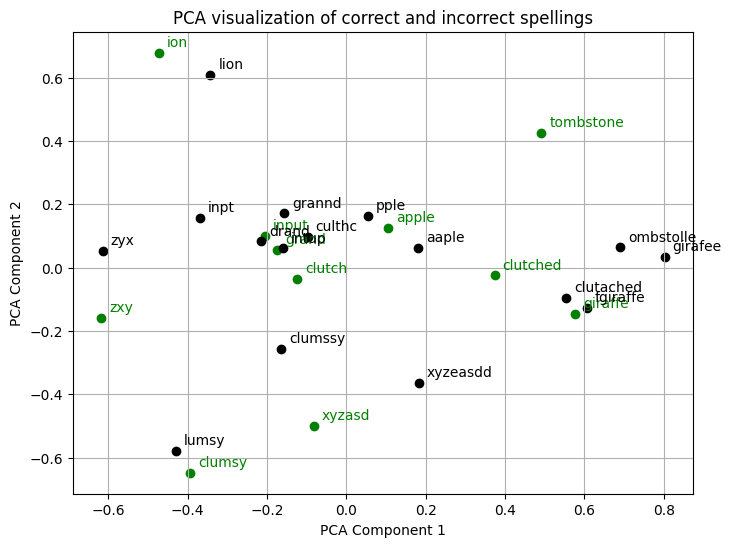

In [48]:
correct_words = ['input', 'clumsy', 'giraffe',"ion","clutch","clutched","xyzasd","zxy","apple","tombstone","grand"]
incorrect_words = ['inpt', 'girafee', 'clumssy', 'fgiraffe', 'lumsy', "intup","lion","culthc","clutached","xyzeasdd","zyx","pple","aaple","ombstolle","drand","grannd"]

correct_embeddings = [loaded_model.get_embedding(loaded_model.get_OHE(word).to(loaded_model.device)) for word in correct_words]
incorrect_embeddings = [loaded_model.get_embedding(loaded_model.get_OHE(word).to(loaded_model.device)) for word in incorrect_words]

all_embeddings = correct_embeddings + incorrect_embeddings

flattened_embeddings = [emb.flatten().cpu().detach().numpy() for emb in all_embeddings]

pca = PCA(n_components=2)
pca_result = pca.fit_transform(flattened_embeddings)

plt.figure(figsize=(8, 6))

for i, (word, color) in enumerate(zip(correct_words + incorrect_words, ['green'] * len(correct_words) + ['black'] * len(incorrect_words))):
    plt.scatter(pca_result[i, 0], pca_result[i, 1], color=color)
    plt.text(pca_result[i, 0] + 0.02, pca_result[i, 1] + 0.02, word, color=color)

plt.title("PCA visualization of correct and incorrect spellings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()